In [25]:
import numpy as np 
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## 0. Preparation 
First, run ``run_models.sh`` to obtain the necessary data for the figure. This script trains all prob. learners and saves the results to the folder ``./results``

## 1. Load predictive means, variances, RMSE and prediction interval coverage rates

In [26]:
methods = ['lli_closed_form', 'lli_vi_closed_form', 'lli_vi_ridge', 'lli_vi_horseshoe',  'lli_gibbs_ridge',  'mc_dropout', 'bnn']
method_names = ['LLI + Gauss + closed form', 'LLI + VI + closed-form + fullCov', 'LLI + VI + Ridge + diagCov',  'LLI + VI + Horseshoe + diagCov', 'LLI + Ridge + Gibbs', 'MC dropout', 'BNN']
#  'lli_vi_ridge', 'lli_vi_horseshoe', 'lli_gibbs_ridge',  , lli_vi_fac_ridge, lli_vi_fac_horseshoe
dict_list = []
for method in methods:
    out_dict_path = Path(f"./results/out_dict_{method}.pkl")

    with open(out_dict_path, "rb") as f:
        loaded_dict = pickle.load(f)
    dict_list.append(loaded_dict.copy())

In [27]:
linestyles =  ['dashed', '-','dashdot', (0, (1, 1)), (0, (3, 5, 1, 5, 1, 5)), 'dotted', (0, (5, 1))] # ,  (0, (3, 5, 1, 5, 1, 5))

## 1. Coverage rates

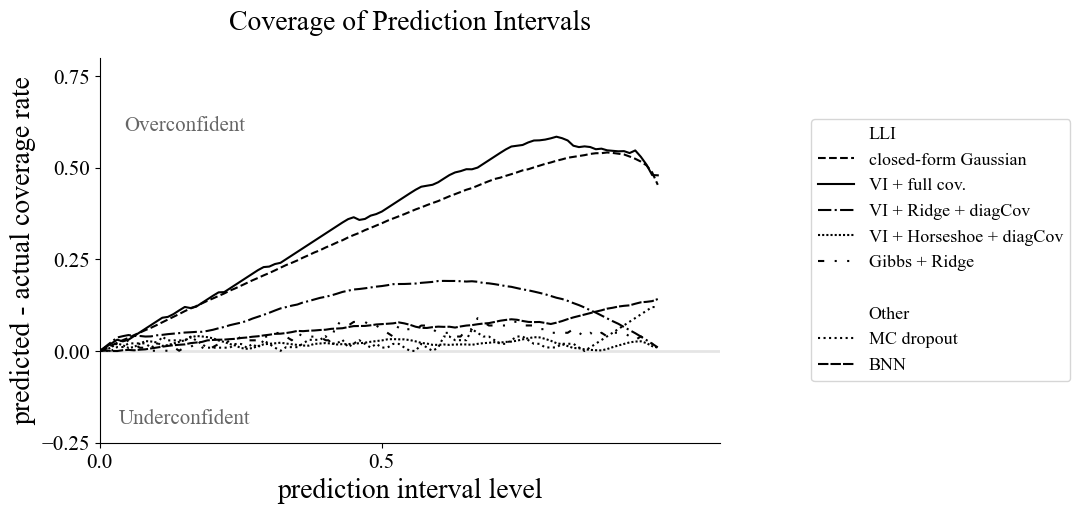

In [28]:

levels = np.linspace(0.001, 0.99, 100)
fig, axs = plt.subplots(1,1, figsize = (8,5))
for method, method_dict, name, linestyle in zip(methods, dict_list, method_names, linestyles):
    axs.plot(levels,  np.abs(levels - method_dict['coverage']), 
                    color = 'black', label = name, linestyle = linestyle
                    )
#axs.legend()
axs.axhline(y=0, color='black', linestyle='-', 
            linewidth=2, label='Ideal', alpha = .1)
axs.legend(loc = 'center right', ncols = 1, fontsize = 10, bbox_to_anchor=(1.58, 0.5)) #
axs.set_xticks(np.arange(-1, 1, .5))
axs.set_yticks(np.arange(-0.25, 1.5, .25))
axs.set_xlim(-0, 1.1)
axs.set_ylim(-.25, .8)
axs.set_title(f'Coverage of Prediction Intervals', pad = 20, size = 20)
axs.grid(False)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_xlabel('prediction interval level', fontsize = 20)
axs.set_ylabel('predicted - actual coverage rate', fontsize = 20)
x_text = 0.15
axs.text(x_text, -0.2, 'Underconfident', fontsize=15, color='black', ha='center', alpha = 0.6)
axs.text(x_text, 0.6, 'Overconfident', fontsize=15, color='black', ha='center', alpha = 0.6)


header_style = dict(linestyle='', color='black', marker='', alpha=0)

# careful! The linestyles here are specified by hand.
legend_elements = [
    Line2D([], [], **header_style, label="LLI"),
    Line2D([0], [0], color='black', linestyle='dashed', label='closed-form Gaussian'),
    Line2D([0], [0], color='black', linestyle='-', label='VI + full cov.'),
    Line2D([0], [0], color='black', linestyle='dashdot', label='VI + Ridge + diagCov'),
    Line2D([0], [0], color='black', linestyle=(0, (1, 1)), label='VI + Horseshoe + diagCov'),
    Line2D([0], [0], color='black', linestyle=(0, (3, 5, 1, 5, 1, 5)), label='Gibbs + Ridge'),
    Line2D([], [], **header_style, label=""),

    Line2D([0], [0], **header_style, label="Other"),
    Line2D([0], [0], color='black', linestyle='dotted', label='MC dropout'),
    Line2D([0], [0], color='black', linestyle=(0, (5, 1)), label='BNN'),
]

axs.legend(handles=legend_elements, loc='center right', fontsize=13, bbox_to_anchor=(1.58, 0.5))
fig.savefig('figures/coverage.pdf', bbox_inches = 'tight')

## 2. RMSE plot

/var/folders/73/tcv3sgb138b9cqckw4zk9r5h0000gn/T/ipykernel_43109/2175341800.py:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


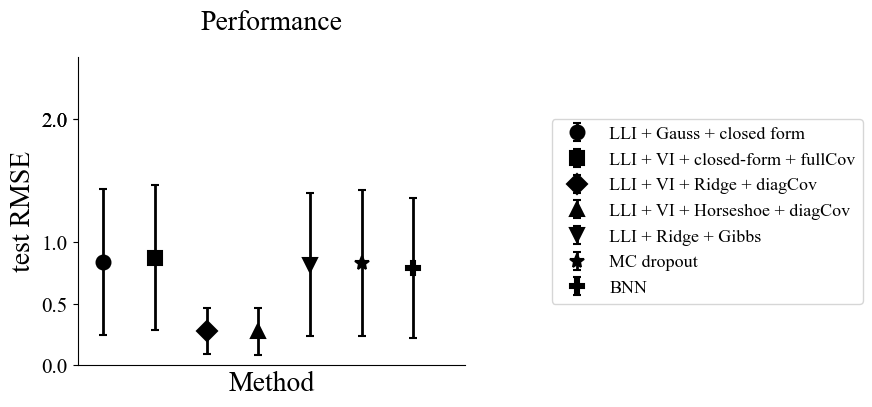

In [32]:
plt.rcParams.update({'font.size': 15, 
                    "font.family": "serif",
                    "font.serif": ["Times New Roman"]})

num_points = 5   # number of methods or configurations per panel
markers = ['o', 's', 'D', '^', 'v', '*', 'P']
# Create horizontal subplots
fig, axs = plt.subplots(1, 1, figsize=(5, 4), sharey=False)


for i, (method_dict, label) in enumerate(zip(dict_list, 
                                    method_names)):
    axs.errorbar(
        x=i, 
        y=method_dict['rmse_mean'], 
        yerr=method_dict['rmse_std'], 
        fmt=markers[i], 
        color='black', 
        markersize=10, 
        capsize=3,
        linewidth=2,
        markeredgewidth=1.5,
        label = label,
    )
axs.set_xticks([])
axs.set_yticks([0, .5,  1, 2,  2])
axs.set_xlim(-0.5, 7)
axs.set_ylim(0, 2.5)
axs.set_title(f'Performance', pad = 20, size = 20)
axs.grid(False)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_xlabel('Method', fontsize = 20)
axs.set_ylabel('test RMSE', fontsize = 20)
axs.legend(loc='center right', fontsize=13, bbox_to_anchor=(2.05, 0.5))

ymin, ymax = axs.get_ylim()
offset = (ymax - ymin) * 0.15

plt.tight_layout()
plt.show()
fig.savefig('figures/rmse.pdf', bbox_inches = 'tight')

In [31]:
method_dict['rmse_mean']

0.7911016941070557